# Homework Set 4

In [1]:
%pylab inline 
import pandas as pd
import inst, fmt

Populating the interactive namespace from numpy and matplotlib


## Problem 1: 

Implement the thomas algorithm for solving tri-diagonal linear systems:

Do your own reading and research on <a href=http://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm>Thomas algorithm</a>  and implement and test it in python.

##Answer 1:

In [2]:
n = 100
m = np.diag(np.random.random(size=n))
np.fill_diagonal(m[:,1:], np.random.random(size=n-1))
np.fill_diagonal(m[1:,:], np.random.random(size=n-1))
d = np.random.random(size=n)

In [3]:
def ThomasAlgorithm(m, d):
    n = size(d)
    
    x,y,z = np.ones(n),np.zeros(n-1),np.zeros(n)
    a,b,c = np.diag(m, k=-1), np.diag(m), np.diag(m, k=1)
    for i in range(n-1):
        if i == 0:
            y[i] = c[i]/b[i]
        else:
            y[i] = c[i]/(b[i]-a[i-1]*y[i-1])
    for i in range(n):
        if i == 0:
            z[i] = d[i]/b[i]
        else:
            z[i] = (d[i]-a[i-1]*z[i-1])/(b[i]-a[i-1]*y[i-1])
    
    r = np.zeros(n)
    l = list(range(0,100))
    l = sorted(l , reverse=True)
    for i in l:
        if i == n-1:
            r[i] = z[i]
        else:
            r[i] = z[i] - y[i]*r[i+1]
            
    return r

In [4]:
r = ThomasAlgorithm(m, d)
r2 = np.linalg.solve(m, d)
print "Test Thomas Algorithm:", np.allclose(r, r2)

Test Thomas Algorithm: True


## Problem 2

Given the following benchmark swap quotes for USD, suppose all swap coupons are paid semi-annually:

In [5]:
mats = np.array([1, 2, 3, 5, 7, 10, 12, 15, 20, 25])*1.
par = np.array([.042, .043, .047, .054, .057, .06, .061, .059, .056, .0555])

df_swap = pd.DataFrame(np.array([par]).T*100, columns=["Par Spread (%)"], 
                       index=map(lambda m: '%dY' % m, mats))
fmt.displayDF(df_swap.T, 2, 2)

,1Y,2Y,3Y,5Y,7Y,10Y,12Y,15Y,20Y,25Y
Par Spread (%),4.2,4.3,4.7,5.4,5.7,6.0,6.1,5.9,5.6,5.5


The swap pricers are provided by the python class ```Swap``` and the pricing function ```priceSwap```, both are defined in <a href=https://raw.githubusercontent.com/yadongli/nyumath2048/master/lib/swap.py>swap.py</a> under the folder nyumath2048/lib of the github repository.

Note the following assumptions of the swap pricer provided:
* it prices a receiver swap, you need to flip the sign to price a payer swap
* it ignores important details, such as day count conventions, do not use this code to trade!

The following are some sample codes of how to use the swap pricers:

In [6]:
from swap import Swap, priceSwap
import lin

# the pricing function if curve(t) is the cumulative yield, ie, -log(b(t))
def y2pv(swap, curve) :
    discf = lambda ts: np.exp(-curve(ts))
    return priceSwap(swap, discf)

# create the benchmark instruments
bm_swaps = {Swap(m, c, 2) : 0 for m, c in zip (mats, par)}

# price a single swap with a straight curve in y(t)
flat = lin.RationalTension(lbd = 5.)
flat.build(mats, mats*.04) # create a dummy curve of flat 0.04 rate

pvs = {swap.maturity : y2pv(swap, flat) for swap in bm_swaps.keys()}
print "PV by maturity"
print "\n".join(["%.2g Y : %.4g" % (m, v) for m, v in pvs.items()])

PV by maturity
1 Y : 0.00155
2 Y : 0.004943
3 Y : 0.01846
5 Y : 0.06101
7 Y : 0.1003
10 Y : 0.1599
12 Y : 0.1943
15 Y : 0.2077
20 Y : 0.2126
25 Y : 0.2362


1. Explain what is the purpose of the +1e-6 in the first line of the priceSwap function
2. Use the market data above to boostrap the IR curve by interpolating the cumulative yield $y(t) = -\log(b(t))$ with tension spline, where $b(t)$ is the discount factor (i.e., the price of risk free zero coupon bonds). After bootstraping the curve, re-price the benchmark instruments using the bootstrapped curve, and compute the L-2 norm of the absolute pricing errors. Show how the pricing error of the bootstraped curve depend on the tension parameter $\lambda$.
3. Using the iteration technique to reduce the L-2 norm of the error below 1bps, how many iteration is needed for the error to go below 1bps?
4. From the curve built in the previous step, compute both the $y(t)$ and the instantaneous forward rate $f(t) = -\frac{1}{b(t)}\frac{d b(t)}{d t} = \frac{d y(t)}{dt}$, and show how their shapes change with the tension parameter $\lambda$. In addition, compare the changes in the instantaneous forward rates with 1bps change in the 5Y par swap rate. You can use the deriv() method in the Tension spline class. 
6. Repeat the previous step, but directly interpolating the forward rates $f(t)$, and comment on whether it is suitable in practice.
5. [extra credit] Build the curve by interpolating the zero rate with tension spline instead, i.e, $r(t) = \frac{y(t)}{t}$, compare how the forward rates shape and perturbations differ from those obtained in step 4, and comment on the pro and cons between interpolating $r(t)$ and $y(t)$.
7. [extra credit] write your own bootstrap function instead of calling those provided by the class library

Hint: 
* write your code in a modular and reusable way; you can re-use the code provided as part of the class lecture, but you get extra credit if you can write your own bootstraping. The source code of the inst package is hidden from you, but you can figure out how to use them by reading their docstring with help(), please use the python codes in the lecture slides as examples.
* be careful with the choice of boundary for the root search, allow negative rates often helps stablizing the bootstraping, even though it does not make economic sense
* in step 5, you may have to mix the old and new results to stablize the iteration, (e.g., use mixf=0.5 in the inst.iterboot function, or your own)

##Answer 2:
1.When comparing the floating point numbers, the limited precision can cause subtle errors. So we can use error bound when comparing floating numbers.

2.Use the market data above to boostrap the IR curve by interpolating the cumulative yield $y(t) = -\log(b(t))$ with tension spline

In [7]:
def BootstrapCurve(benchmark, pfunc, lambdas, x0, bds, mixf, iterations):
    es = []
    cvs = []
    
    for lbd in lambdas:
        tsit, e = inst.iterboot(benchmark, pfunc, lbd=lbd, x0=x0, its=iterations, bds=bds, mixf = mixf)
        es.append(e[-1])
        cvs.append(tsit)
        
    return cvs, es

 After bootstraping the curve, re-price the benchmark instruments using the bootstrapped curve, and compute the L-2 norm of the absolute pricing errors. Show how the pricing error of the bootstraped curve depend on the tension parameter $\lambda$.

,1Y,2Y,3Y,5Y,7Y,10Y,12Y,15Y,20Y,25Y
Fit Error (bps) $\lambda$=0,1.6581,1.4622,1.3095,16.6245,10.7534,71.0006,4.0462,20.0583,55.7215,-0.0000
Fit Error (bps) $\lambda$=2,0.8438,1.0859,0.8003,10.4786,7.4044,45.1446,5.8766,12.2391,41.1074,0.0000
Fit Error (bps) $\lambda$=10,0.3025,0.4716,0.3304,4.4641,3.2971,19.7228,3.3244,5.2672,19.4523,0.0000
Fit Error (bps) $\lambda$=100,0.0376,0.0631,0.0438,0.6108,0.4596,2.7789,0.5045,0.7392,2.8797,-0.0000


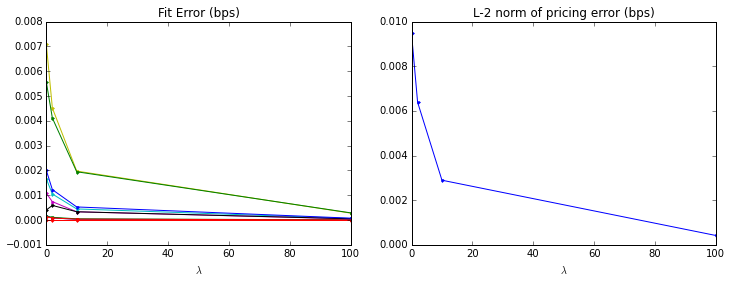

In [8]:
lbds = [0, 2, 10, 100]
terms = np.array([1, 2, 3, 5, 7, 10, 12, 15, 20, 25])

cvs, es = BootstrapCurve(bm_swaps, y2pv, lbds, x0 = 0, bds = [0., 2.], mixf = 0, iterations = 1)

df = pd.DataFrame(np.array(es)*1e4, index=['Fit Error (bps) $\\lambda$=%g' % l for l in lbds], 
                  columns = ['%gY' % t for t in terms])
fmt.displayDF(df, "4f")

figure(figsize=[12, 4])
subplot(1, 2, 1)
xlabel('$\lambda$')
plot(lbds, es, '.-')
title('Fit Error (bps)')

subplot(1, 2, 2)
xlabel('$\lambda$')
plot(lbds, np.linalg.norm(es, 2, 1), '.-')
title('L-2 norm of pricing error (bps)')

3.Using the iteration technique to reduce the L-2 norm of the error below 1bps. At least two iterations are needed for the error to go below 1bps.

,1Y,2Y,3Y,5Y,7Y,10Y,12Y,15Y,20Y,25Y
Fit Error (bps) $\lambda$=0,0.0056,-0.0017,0.0162,-0.0579,0.3464,-0.2377,0.0024,0.2919,-0.3567,0.0000
Fit Error (bps) $\lambda$=2,0.0015,0.0002,0.0045,0.0081,0.1155,-0.0392,0.0035,0.1171,-0.1753,-0.0000
Fit Error (bps) $\lambda$=10,0.0002,0.0001,0.0007,0.0037,0.0188,-0.0021,0.0013,0.0213,-0.0365,0.0000
Fit Error (bps) $\lambda$=100,0.0000,0.0000,0.0000,0.0001,0.0003,-0.0000,0.0000,0.0004,-0.0008,-0.0000


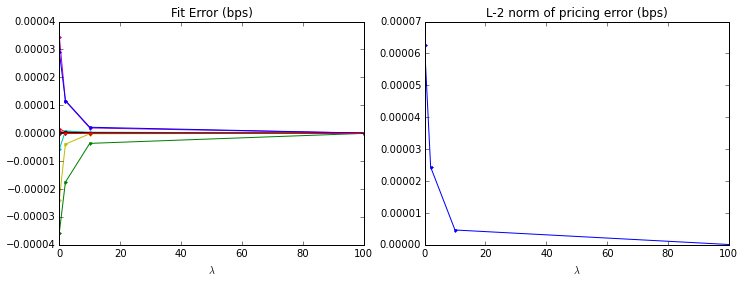

In [9]:
cvs, es = BootstrapCurve(bm_swaps, y2pv, lbds, x0 = 0, bds = [0., 2.], mixf = 0, iterations = 2)

df = pd.DataFrame(np.array(es)*1e4, index=['Fit Error (bps) $\\lambda$=%g' % l for l in lbds], 
                  columns = ['%gY' % t for t in terms])
fmt.displayDF(df, "4f")

figure(figsize=[12, 4])
subplot(1, 2, 1)
xlabel('$\lambda$')
plot(lbds, es, '.-')
title('Fit Error (bps)')

subplot(1, 2, 2)
xlabel('$\lambda$')
plot(lbds, np.linalg.norm(es, 2, 1), '.-')
title('L-2 norm of pricing error (bps)')

4.From the curve built in the previous step, compute both the $y(t)$ and the instantaneous forward rate $f(t) = -\frac{1}{b(t)}\frac{d b(t)}{d t} = \frac{d y(t)}{dt}$, and show how their shapes change with the tension parameter $\lambda$.

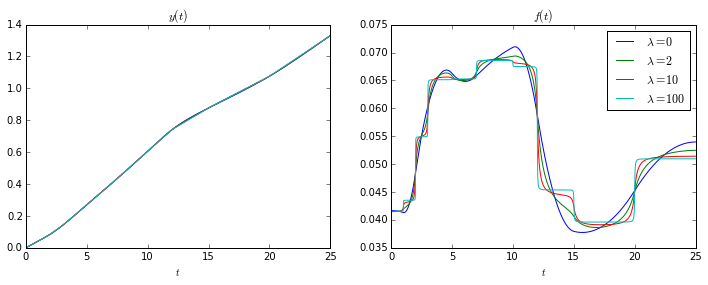

In [10]:
lbds = (0, 2, 10, 100)
tags = ['$\\lambda=%.f$' % l for l in lbds]
xs = np.arange(.01, 25, .01)
cv0, es = BootstrapCurve(bm_swaps, y2pv, lbds, x0 = 0, bds = [0., 2.], mixf = 0, iterations = 2)

figure(figsize=[12, 4])
subplot(1, 2, 1)
plot(xs, np.array([cv(xs) for cv in cv0]).T)
title('$y(t)$')
xlabel('$t$')

subplot(1, 2, 2)
plot(xs, np.array([cv.deriv(xs) for cv in cv0]).T)
legend(tags, loc='best')
title('$f(t)$')
xlabel('$t$')

 In addition, compare the changes in the instantaneous forward rates with 1bps change in the 5Y par swap rate.

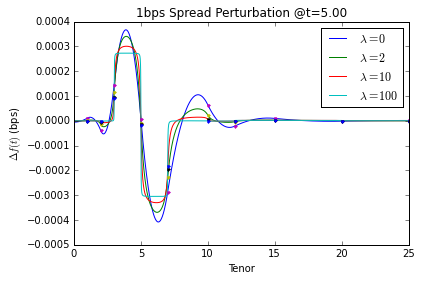

In [11]:
def showPerts(bms, bms_ps, cdspv, lbds, x0, pertf) :
    cv0, es0 = BootstrapCurve(bms, cdspv, lbds, x0 = 0, bds = [0., 2.], mixf = 0, iterations = 2)
    cvp, es1 = BootstrapCurve(bms_ps, cdspv, lbds, x0 = 0 , bds = [0., 2.], mixf = 0, iterations = 2)
    
    lbd_tags = ['$\\lambda=%.f$' % lbd for lbd in lbds]

    figure(figsize=[6, 4])

    plot(xs, np.array([pertf(f, g)(xs) for f, g in zip(cv0, cvp)]).T)
    xlabel('Tenor')
    ylabel('$\Delta f(t)$ (bps)')
    title('1bps Spread Perturbation @t=%.2f' % pt)
    legend(lbd_tags, loc='best');
    plot(terms, np.array([pertf(f, g)(terms) for f, g in zip(cv0, cvp)]).T, '.')


    
    
pt = 5
bms_ps = {k if k.maturity != pt else Swap(k.maturity, k.coupon-1e-4, k.freq) : v 
        for k, v in bm_swaps.items()}
    
showPerts(bm_swaps, bms_ps, y2pv, lbds, 0, lambda f, g : lambda xs : f.deriv(xs) - g.deriv(xs))

5.Repeat the previous step, but directly interpolating the forward rates $f(t)$. Perturbation in a single tenor generates waves throughout the forward rate structure.In practice, it is a distaster.

In [12]:
# the forward rate function if curve(t) is the cumulative yield
def f2pv(swap, curve) :
    discf = lambda ts: np.exp(-curve.integral(ts))
    return priceSwap(swap, discf)

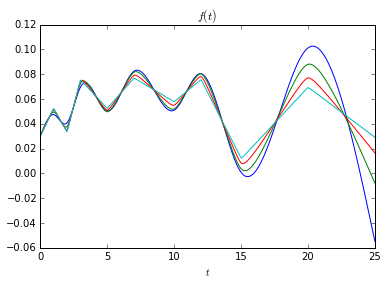

In [13]:
lbds = (0, 2, 10, 100)
tags = ['$\\lambda=%.f$' % l for l in lbds]
xs = np.arange(.01, 25, .01)
cv0, es = BootstrapCurve(bm_swaps, f2pv, lbds, x0 = 0.03, bds = [-1., 1.], mixf = 0.5, iterations = 6)


plot(xs, np.array([cv(xs) for cv in cv0]).T);
title('$f(t)$')
xlabel('$t$')

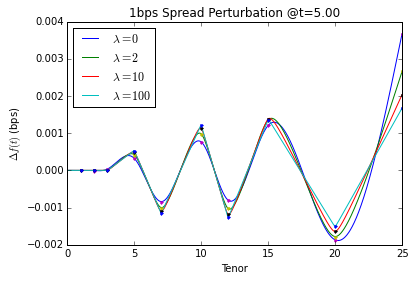

In [14]:
def showPerts_new(bms, bms_ps, cdspv, lbds, x0, pertf) :
    cv0, es0 = BootstrapCurve(bms, cdspv, lbds, x0 = 0.03, bds = [-1., 1.], mixf = 0.5, iterations = 6)
    cvp, es1 = BootstrapCurve(bms_ps, cdspv, lbds, x0 = 0.03 , bds = [-1., 1.], mixf = 0.5, iterations = 6)
    
    lbd_tags = ['$\\lambda=%.f$' % lbd for lbd in lbds]

    figure(figsize=[6, 4])

    plot(xs, np.array([pertf(f, g)(xs) for f, g in zip(cv0, cvp)]).T)
    xlabel('Tenor')
    ylabel('$\Delta f(t)$ (bps)')
    title('1bps Spread Perturbation @t=%.2f' % pt)
    legend(lbd_tags, loc='best');
    plot(terms, np.array([pertf(f, g)(terms) for f, g in zip(cv0, cvp)]).T, '.')


    
    
pt = 5
bms_ps = {k if k.maturity != pt else Swap(k.maturity, k.coupon-1e-4, k.freq) : v 
        for k, v in bm_swaps.items()}
    
showPerts_new(bm_swaps, bms_ps, f2pv, lbds, 0, lambda f, g : lambda xs : f(xs) - g(xs))